
# Results for experiments over KDDCup dataset

In [1]:
%matplotlib inline
from IPython.display import display

import matplotlib.pyplot as plt
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')
seaborn.set_palette('colorblind')

In [3]:
METRICS_COLS = ['AUC', 'RMSE', 'Accuracy', 'R2']

In [4]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [5]:
ANCHOR_COURSES = [1, 6, 16]

In [6]:
def read_predictions(filename):
    with open(filename, 'rb') as prediction_file:
        return pickle.load(prediction_file)

def read_file_metrics(true, predicted):
    """Returns a DataFrame with values AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    try:
        results.append([metrics.roc_auc_score(true, predicted)])
    except ValueError:
        ignored_sequences += 1
        results.append([numpy.nan])
    results[-1].append(metrics.mean_squared_error(true, predicted)**0.5)
    results[-1].append(metrics.accuracy_score(true, numpy.where(predicted > 0.5, 1, 0)))
    results[-1].append(metrics.r2_score(true, predicted))
    results[-1].append(metrics.recall_score(true, numpy.round(predicted), labels=[0, 1], average=None)[1])
    results[-1].append(true.shape[0])
    if ignored_sequences > 0:    
        print('{} sequences with only one class, ignoring.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=METRICS_COLS + ['PositiveRecall', 'Support'])

In [7]:
def read_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        trues, predictions = [], []
        for filename in get_runs(dirname):
            true, predicted = read_predictions(os.path.join(dirname, filename))
            file_metrics = read_file_metrics(true, predicted)
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                file_metrics['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                file_metrics['Course'] = 1
            metrics_dfs.append(file_metrics)
            trues.append(true)
            predictions.append(predicted)
        general_metrics = read_file_metrics(numpy.concatenate(trues), numpy.concatenate(predictions))
        general_metrics['Experiment'] = dirname[-16:]
        general_metrics['Run'] = -1
        general_metrics['Course'] = -1
        metrics_dfs.append(general_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True).set_index(['Experiment', 'Run', 'Course'])

In [8]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'], dtype=numpy.float32)
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'], dtype=numpy.float32)
            train['Dataset'] = 'train'
            validation['Dataset'] = 'validation'
            concat = pandas.concat([train, validation])
            concat['Run'] = re.search('.*run(\d+).*', filename).group(1)
            course = re.search('.*_c(\d+)_.*', filename)
            if course is not None:
                concat['Course'] = int(re.search('.*_c(\d+)_.*', filename).group(1))
            else:
                concat['Course'] = 1
            concat['rmse'] = concat['mse']**0.5
            dataframes.append(concat)
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    performances = []
    for dirname, performance_dataframe in train_performances.items():
        perf = performance_dataframe.groupby(['epoch', 'Run', 'Course']).agg({'rmse': 'std'}).groupby(
            'Course').agg('mean')
        perf['Experiment'] = dirname[-16:]
        performances.append(perf.reset_index())
    performances = pandas.concat(performances, ignore_index=True)
    seaborn.factorplot(x='Course', y='rmse', col="Experiment", data=performances, col_wrap=4)

def graphic_learning_curves(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        performance_dataframe['epoch'] = performance_dataframe.epoch.astype(numpy.int)
        grid = seaborn.FacetGrid(data=performance_dataframe.loc[performance_dataframe['Run'] == '0'],
                                 col='Course', despine=True, ylim=[0, 0.5], aspect=1,
                                 palette='colorblind')
        mapped = grid.map(seaborn.pointplot, 'epoch', 'rmse', 'Dataset').add_legend().set_xticklabels([])
        plt.show()

### Real distribution of labels

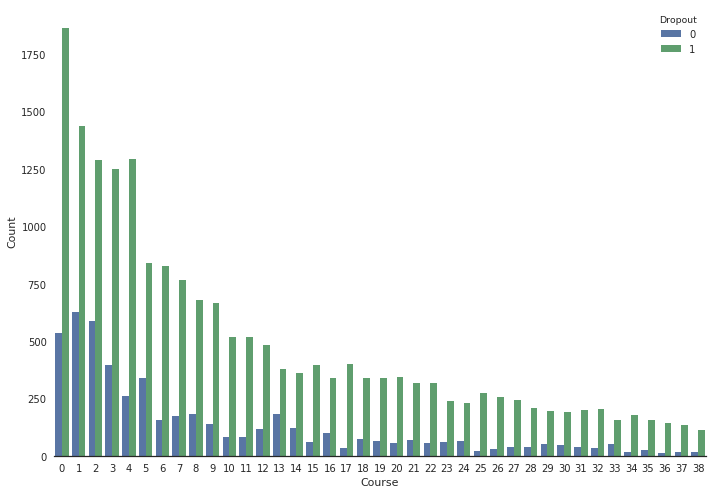

In [9]:
label_dfs = []
dirname = '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-06/predictions_c{}_run0.p'
for course in range(0, 39):
    true, _ = read_predictions(dirname.format(course))
    for label in [0, 1]:
        label_dfs.append({'Course': course, 'Dropout': label, 'Count': true[true == label].shape[0]})
label_dfs = pandas.DataFrame(label_dfs)
seaborn.set(style='white', rc={'figure.figsize':(11.7,8.27)})
seaborn.barplot(x='Course', y='Count', hue='Dropout', data=label_dfs)
seaborn.despine(left=True)

In [10]:
label_dfs.groupby('Dropout').agg('sum')

,Count,Course
Dropout,,
0,5052,741
1,19072,741


In [11]:
dropout_proportions = label_dfs.groupby(['Course', 'Dropout']).agg('sum')
dropout_proportions['Proportion'] = numpy.nan
for course in dropout_proportions.reset_index().Course:
    dropout_count = dropout_proportions.loc[course, 0].Count
    nodropout_count = dropout_proportions.loc[course, 1].Count
    dropout_proportions.loc[(course, 0),['Proportion']] = dropout_count / (dropout_count + nodropout_count)
    dropout_proportions.loc[(course, 1),['Proportion']] = nodropout_count / (dropout_count + nodropout_count)
dropout_proportions

Count  Proportion
Course Dropout                   
0      0          536    0.223240
       1         1865    0.776760
1      0          628    0.304116
       1         1437    0.695884
2      0          588    0.313266
       1         1289    0.686734
3      0          396    0.240729
       1         1249    0.759271
4      0          261    0.167846
       1         1294    0.832154
5      0          338    0.286927
       1          840    0.713073
6      0          155    0.158163
       1          825    0.841837
7      0          173    0.184632
       1          764    0.815368
8      0          182    0.211137
       1          680    0.788863
9      0          137    0.170823
       1          665    0.829177
10     0           84    0.139767
       1          517    0.860233
11     0           82    0.136895
       1          517    0.863105
12     0          116    0.194305
       1          481    0.805695
13     0          181    0.323214
       1          379    0.676786
14     0          120    0.250522
       1          359    0.749478
...               ...         ...
24     0           65    0.219595
       1          231    0.780405
25     0           22    0.074576
       1          273    0.925424
26     0           28    0.097902
       1          258    0.902098
27     0           39    0.138790
       1          242    0.861210
28     0           38    0.153226
       1          210    0.846774
29     0           53    0.214575
       1          194    0.785425
30     0           48    0.201681
       1          190    0.798319
31     0           39    0.163866
       1          199    0.836134
32     0           35    0.147679
       1          202    0.852321
33     0           52    0.250000
       1          156    0.750000
34     0           16    0.082051
       1          179    0.917949
35     0           24    0.133333
       1          156    0.866667
36     0           12    0.077922
       1          142    0.922078
37     0           18    0.117647
       1          135    0.882353
38     0           16    0.124031
       1          113    0.875969

[78 rows x 2 columns]

## Experiments with LSTM model

In [99]:
LSTM_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-09-35/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-19-47/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-29/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/17-12-21-20-38/',
#     '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-04-12-39/', # Truncated
    # Not filtered
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-17-13-47/',
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-27-15-06/',  # Full eval
    '/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-27-21-28',  # Full eval
]

## Learning curves

In [100]:
lstm_performances = read_performances(LSTM_EXPERIMENTS_DIRS)

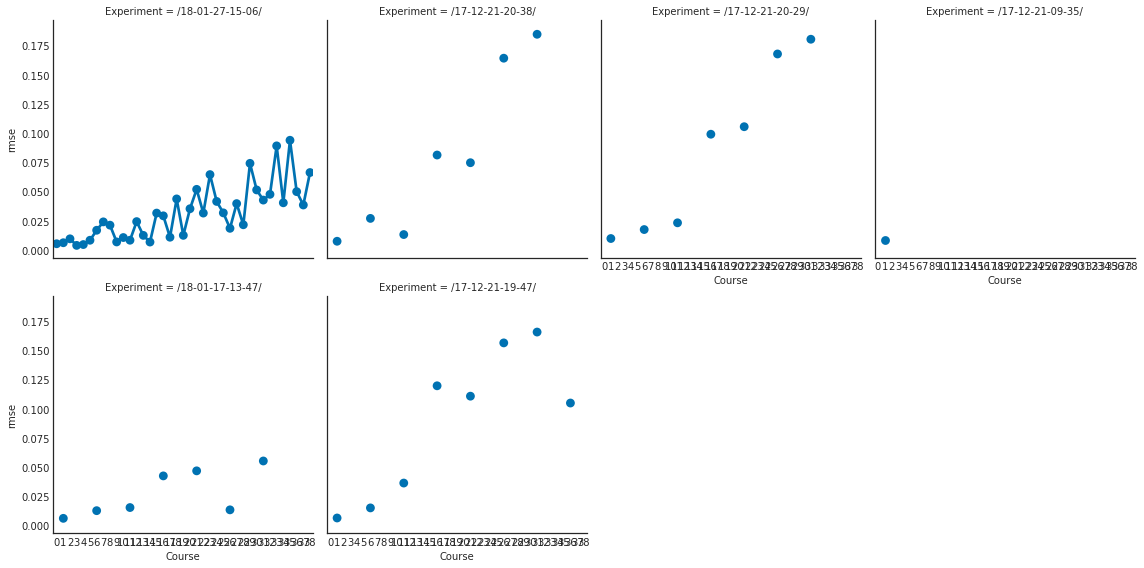

In [43]:
graphic_performances(lstm_performances)

In [24]:
for dirname, dataframe in lstm_performances.items():
    print(dirname)
    idx = dataframe.groupby(['Dataset', 'Course'])['epoch'].transform(max) == dataframe['epoch']
    display(dataframe[idx].groupby(['Course', 'Dataset']).agg('mean'))

/home/mteruel/edm/results/kddcup/lstm/predictions/18-01-27-15-06/


epoch       mse      rmse
Course Dataset                              
0      train       450.0  0.119462  0.345595
       validation  450.0  0.128060  0.357674
1      train       450.0  0.113074  0.336265
       validation  450.0  0.121499  0.348567
2      train       450.0  0.118586  0.344361
       validation  450.0  0.124399  0.352500
3      train       450.0  0.122326  0.349751
       validation  450.0  0.120412  0.346965
4      train       450.0  0.081093  0.284768
       validation  450.0  0.077276  0.277980
5      train       450.0  0.112596  0.335553
       validation  450.0  0.122098  0.349398
6      train       450.0  0.081952  0.286272
       validation  450.0  0.071622  0.267609
7      train       450.0  0.088907  0.298170
       validation  450.0  0.122646  0.350202
8      train       450.0  0.118424  0.344123
       validation  450.0  0.151541  0.389237
9      train       450.0  0.086310  0.293782
       validation  450.0  0.098741  0.314067
10     train       450.0  0.080312  0.283358
       validation  450.0  0.098407  0.313143
11     train       450.0  0.068847  0.262350
       validation  450.0  0.080947  0.284425
12     train       450.0  0.071768  0.267787
       validation  450.0  0.104877  0.323478
13     train       450.0  0.069439  0.263461
       validation  450.0  0.061955  0.248892
14     train       450.0  0.094219  0.306951
       validation  450.0  0.099408  0.315082
...                  ...       ...       ...
24     train       450.0  0.053727  0.231786
       validation  450.0  0.120180  0.346500
25     train       450.0  0.046149  0.214772
       validation  450.0  0.054848  0.230864
26     train       450.0  0.050772  0.225322
       validation  450.0  0.070493  0.264665
27     train       450.0  0.067654  0.259783
       validation  450.0  0.110952  0.332668
28     train       450.0  0.063607  0.252148
       validation  450.0  0.111187  0.333445
29     train       450.0  0.031903  0.178435
       validation  450.0  0.133839  0.365737
30     train       450.0  0.056895  0.238398
       validation  450.0  0.138990  0.372396
31     train       450.0  0.055984  0.236608
       validation  450.0  0.141390  0.374552
32     train       450.0  0.028505  0.168819
       validation  450.0  0.092695  0.304300
33     train       450.0  0.028274  0.168038
       validation  450.0  0.173280  0.414947
34     train       450.0  0.021181  0.145237
       validation  450.0  0.051134  0.221602
35     train       450.0  0.025018  0.158068
       validation  450.0  0.117733  0.341859
36     train       450.0  0.027688  0.165291
       validation  450.0  0.074438  0.271719
37     train       450.0  0.026849  0.163755
       validation  450.0  0.079402  0.280404
38     train       450.0  0.024321  0.153139
       validation  450.0  0.071194  0.260462

[78 rows x 3 columns]

## Performance Metrics

In [101]:
lstm_metrics = read_metrics(LSTM_EXPERIMENTS_DIRS)

In [102]:
lstm_metrics.groupby(['Experiment', 'Course']).aggregate('mean')#[METRICS_COLS]

AUC      RMSE  Accuracy        R2  \
Experiment       Course                                           
/18-01-17-13-47/ -1      0.837232  0.335478  0.856614  0.345277   
                  1      0.871481  0.341300  0.854722  0.449573   
                  6      0.841756  0.289848  0.895408  0.368997   
                  11     0.815269  0.298726  0.883973  0.244654   
                  16     0.741369  0.386294  0.796380  0.153441   
                  21     0.661904  0.418368  0.771318 -0.194712   
                  26     0.863580  0.270556  0.912587  0.168719   
                  31     0.820191  0.362831  0.827731  0.038607   
/18-01-27-15-06/ -1      0.820284  0.333971  0.859621  0.326317   
                  0      0.841286  0.336868  0.850271  0.345556   
                  1      0.870635  0.338687  0.851332  0.457969   
                  2      0.850787  0.350992  0.847896  0.427343   
                  3      0.782626  0.370522  0.823100  0.248524   
                  4      0.846842  0.286426  0.900000  0.412617   
                  5      0.867132  0.341049  0.845501  0.431445   
                  6      0.836966  0.288551  0.896429  0.374665   
                  7      0.794932  0.326064  0.867129  0.293332   
                  8      0.771596  0.363264  0.826566  0.207632   
                  9      0.797486  0.351760  0.828554  0.126278   
                  10     0.815073  0.304003  0.875208  0.230816   
                  11     0.794558  0.303981  0.879800  0.217425   
                  12     0.847041  0.314636  0.878559  0.367057   
                  13     0.931347  0.246442  0.933929  0.722342   
                  14     0.867630  0.341209  0.843424  0.379837   
                  15     0.706514  0.316203  0.874449  0.127947   
                  16     0.747989  0.389705  0.799774  0.138481   
                  17     0.663545  0.247261  0.933875  0.135288   
                  18     0.688012  0.370840  0.824818  0.047342   
                  19     0.866859  0.273250  0.914179  0.434873   
                  20     0.707531  0.319715  0.879052  0.149222   
...                           ...       ...       ...       ...   
s/18-01-27-21-28  9      0.795878  0.355076  0.834788  0.109878   
                  10     0.820156  0.301461  0.885191  0.244077   
                  11     0.798144  0.309858  0.881469  0.187404   
                  12     0.842032  0.312490  0.880235  0.376234   
                  13     0.933461  0.253029  0.928571  0.707315   
                  14     0.875557  0.334846  0.844468  0.402754   
                  15     0.689319  0.319518  0.879956  0.109765   
                  16     0.736419  0.400293  0.788462  0.091079   
                  17     0.666629  0.250673  0.929234  0.110648   
                  18     0.705383  0.357299  0.844282  0.116302   
                  19     0.860514  0.275549  0.910448  0.425467   
                  20     0.689130  0.331232  0.874065  0.086557   
                  21     0.658714  0.408879  0.789406 -0.141370   
                  22     0.678683  0.354697  0.847074  0.021038   
                  23     0.713431  0.400625  0.811448 -0.008605   
                  24     0.768032  0.344415  0.863176  0.307808   
                  25     0.705711  0.263161  0.920339 -0.003485   
                  26     0.802049  0.293374  0.903846  0.024418   
                  27     0.717472  0.330202  0.871886  0.087546   
                  28     0.545551  0.379054  0.836694 -0.108714   
                  29     0.723157  0.395779  0.819838  0.070529   
                  30     0.760746  0.393927  0.821429  0.036181   
                  31     0.805309  0.371953  0.838235 -0.009787   
                  32     0.852475  0.260868  0.919831  0.458754   
                  33     0.607865  0.438035  0.786058 -0.023663   
                  34     0.621334  0.282919  0.910256 -0.062823   
                  35     0.744391  0.332076  0.877778  0.044780   
          

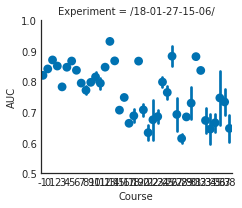

In [27]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.5, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

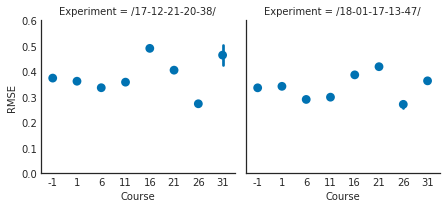

In [48]:
grid = seaborn.FacetGrid(data=lstm_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with Embedded LSTM model

In [195]:
EMBEDDING_EXPERIMENTS_DIRS = [
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-51/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-09-59/',
#      '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-02/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-10-59/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-11-05/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-19-28/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/17-12-21-21-04/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-03-17-53/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-03-10-28/',
# #     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-33/',
#     '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-09-20-49/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-15/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-10-14-58/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-11-14-38/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-18-40/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-12-19-06/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-13-21-15/',
#     '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-28-01-23/',  # Full eval filtered
    # Not filtered
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-17-14-01/',
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-17-14-46/',
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-22-21-50/', # Full eval
    '/home/mteruel/edm/results/kddcup/embedding/pretrained/predictions/18-01-27-22-16/',  # Full eval
    '/home/mteruel/edm/results/kddcup/embedding/predictions/18-01-28-23-57/', # Full eval
]

## Learning curves

In [178]:
embedding_performances = read_performances(EMBEDDING_EXPERIMENTS_DIRS)

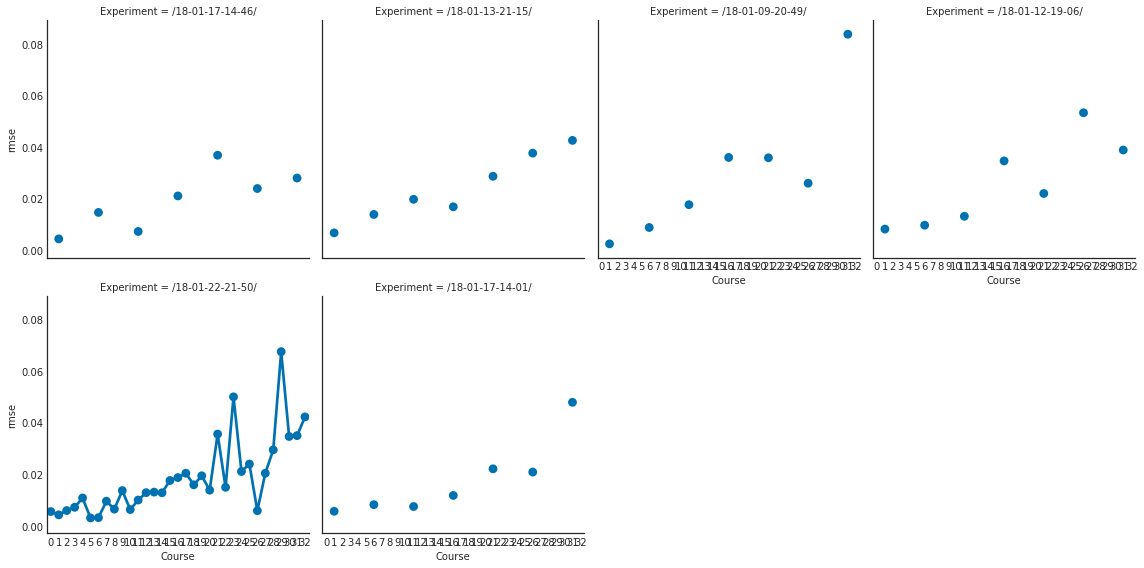

In [78]:
graphic_performances(embedding_performances)

## Performance Metrics

In [196]:
embedding_metrics = read_metrics(EMBEDDING_EXPERIMENTS_DIRS)

In [180]:
embedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-17-14-01/ -1      0.849845  0.329682  0.862417  0.367703
                  1      0.887088  0.337781  0.852542  0.460796
                  6      0.850499  0.290615  0.895408  0.365689
                  11     0.805503  0.298939  0.891486  0.243663
                  16     0.782773  0.379327  0.806561  0.183768
                  21     0.699253  0.395770  0.812661 -0.069351
                  26     0.803225  0.271656  0.912587  0.163587
                  31     0.853369  0.328515  0.863445  0.207883
/18-01-22-21-50/ -1      0.839115  0.328006  0.863038  0.357483
                  0      0.850717  0.341634  0.845065  0.326810
                  1      0.885296  0.332746  0.858354  0.476821
                  2      0.864437  0.346836  0.848695  0.440823
                  3      0.787477  0.363798  0.826444  0.275890
                  4      0.849271  0.288464  0.897428  0.404234
                  5      0.874520  0.343559  0.841256  0.423073
                  6      0.854002  0.290207  0.896429  0.367456
                  7      0.807289  0.317341  0.877268  0.331018
                  8      0.785694  0.366042  0.815545  0.195554
                  9      0.812156  0.340523  0.841022  0.181249
                  10     0.845071  0.295380  0.888519  0.274108
                  11     0.795985  0.298560  0.883139  0.245552
                  12     0.872294  0.300747  0.890285  0.422240
                  13     0.932455  0.245859  0.933929  0.723660
                  14     0.882277  0.330839  0.851775  0.417044
                  15     0.718761  0.320366  0.878855  0.102826
                  16     0.796783  0.375332  0.805430  0.200867
                  17     0.697883  0.233568  0.939675  0.228397
                  18     0.778956  0.340854  0.860097  0.195941
                  19     0.879665  0.273630  0.909204  0.433313
                  20     0.761335  0.312341  0.882793  0.187935
                  21     0.721653  0.390860  0.807494 -0.042875
                  22     0.734450  0.335620  0.867021  0.123416
                  23     0.769086  0.355546  0.845118  0.205899
                  24     0.835931  0.333684  0.856419  0.348329
                  25     0.760240  0.264864  0.916949 -0.017066
                  26     0.830565  0.269207  0.914336  0.179240
                  27     0.797150  0.300543  0.891459  0.242501
                  28     0.631454  0.347016  0.860887  0.070911
                  29     0.682066  0.405076  0.817814  0.026362
                  30     0.722917  0.407473  0.792017 -0.031436
                  31     0.880299  0.293416  0.897059  0.371512
                  32     0.890877  0.246707  0.930380  0.514347
/18-01-28-23-57/ -1      0.752815  0.326253  0.876194  0.103781
                  32     0.877298  0.236386  0.934599  0.555906
                  33     0.788955  0.400276  0.807692  0.145400
                  34     0.619413  0.279567  0.912821 -0.037992
                  35     0.658120  0.347777  0.852778 -0.046719
                  36     0.607394  0.252290  0.931818  0.110771
                  37     0.738066  0.385355  0.830065 -0.431100
                  38     0.659845  0.368561  0.844961 -0.250565

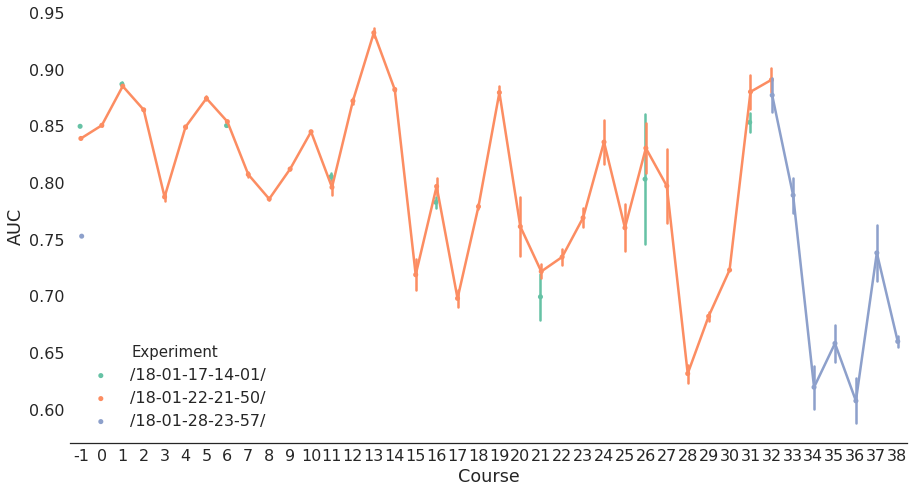

In [181]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

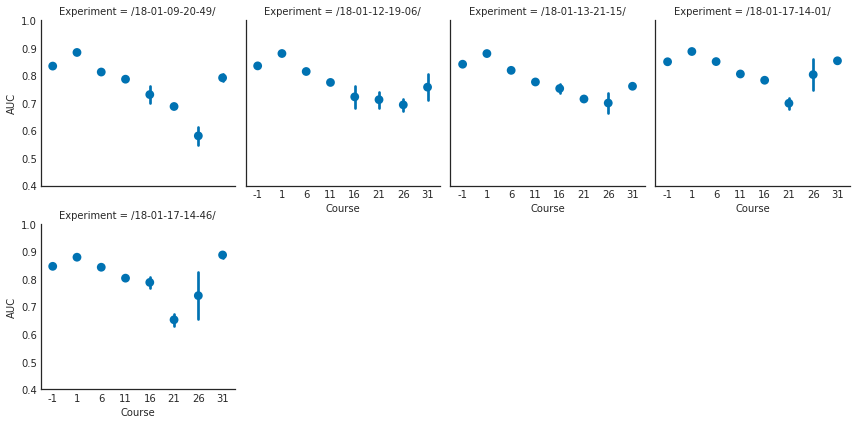

In [55]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0.4, 1])
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

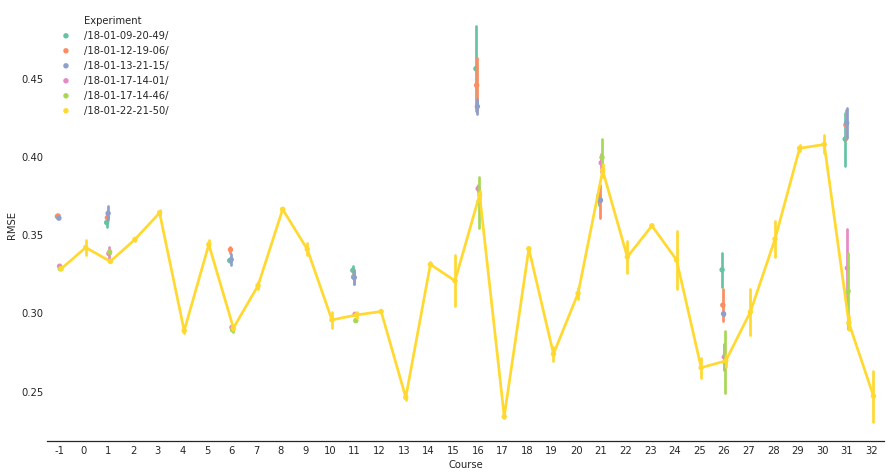

In [82]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=embedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

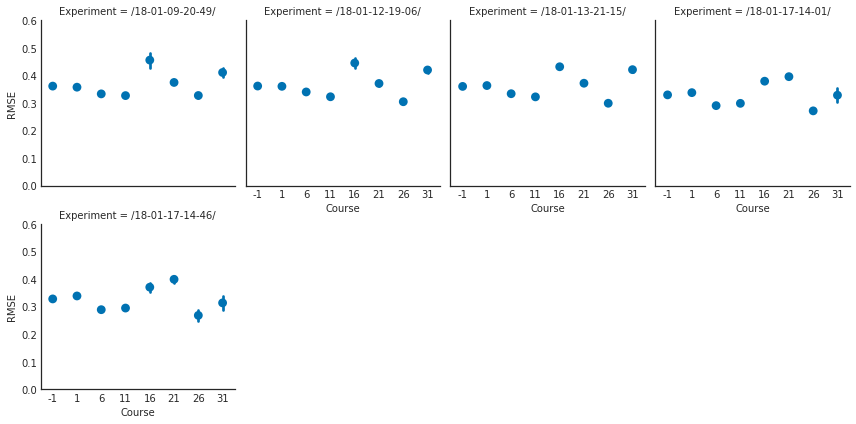

In [57]:
grid = seaborn.FacetGrid(data=embedding_metrics.reset_index(), col='Experiment', col_wrap=4, ylim=[0, 0.6])
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

## Experiments with CO-Embedde LSTM model

In [193]:
COEMBEDDING_EXPERIMENTS_DIRS = [
    #'/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-09/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-12-57/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-20-56/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-13/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/17-12-21-21-22/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-03-12-22/',  # Truncated
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-04-09-45/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-05-17-37/',
#     '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-09-18-19/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-18-46/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-09-20-18/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-14-18/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-10-23-03/',
# # #     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-11-16-32/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-09-49/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-12-10-31/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-13-20-35/',
#     '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-28-10-59/',  # Full eval filtered
    # No filtered
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-17-15-29/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-17-16-25/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-06/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-57/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-26-09-41/',
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-26-20-05/',
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-22-18-06/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/predictions/18-01-28-18-51/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-28-20-07/',  # Full eval
    '/home/mteruel/edm/results/kddcup/coembedding/pretrained/predictions/18-01-29-00-26/',  # Full eval
]

## Learning curves

In [141]:
coembedding_performances = read_performances(COEMBEDDING_EXPERIMENTS_DIRS)

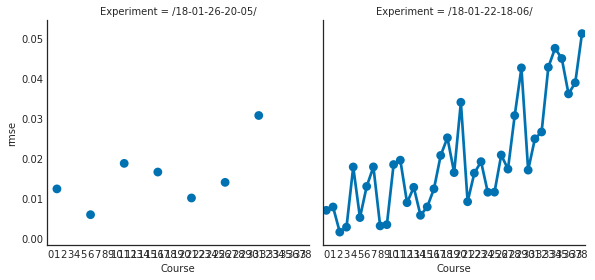

In [18]:
graphic_performances(coembedding_performances)

## Performance Metrics

In [194]:
coembedding_metrics = read_metrics(COEMBEDDING_EXPERIMENTS_DIRS)

In [189]:
coembedding_metrics.groupby(['Experiment', 'Course']).aggregate('mean')[METRICS_COLS][-40:]

AUC      RMSE  Accuracy        R2
Experiment       Course                                        
/18-01-29-00-26/ -1      0.832033  0.329124  0.861963  0.345729
                  0      0.844074  0.343852  0.842566  0.318116
                  1      0.876658  0.338120  0.853511  0.459778
                  2      0.853745  0.352788  0.842568  0.421433
                  3      0.774668  0.367386  0.821277  0.261552
                  4      0.845261  0.287404  0.900965  0.408612
                  5      0.859887  0.349765  0.839983  0.402069
                  6      0.839699  0.291707  0.889796  0.360869
                  7      0.794813  0.323135  0.875667  0.306377
                  8      0.787221  0.359793  0.825986  0.222783
                  9      0.789435  0.344372  0.836035  0.162692
                  10     0.831583  0.294060  0.889351  0.280717
                  11     0.802366  0.297886  0.888147  0.248963
                  12     0.853314  0.302926  0.890285  0.413829
                  13     0.926202  0.250838  0.926786  0.712357
                  14     0.871959  0.338381  0.847599  0.390152
                  15     0.743591  0.308831  0.884361  0.167983
                  16     0.794054  0.369292  0.813348  0.226395
                  17     0.696894  0.239283  0.932715  0.189634
                  18     0.756125  0.339019  0.855231  0.204508
                  19     0.883340  0.269102  0.916667  0.452023
                  20     0.763975  0.321295  0.877805  0.139511
                  21     0.750547  0.364996  0.825581  0.090379
                  22     0.755101  0.331943  0.868351  0.142942
                  23     0.757157  0.345618  0.853535  0.249382
                  24     0.802498  0.334628  0.871622  0.346595
                  25     0.810689  0.249373  0.922034  0.098874
                  26     0.870570  0.246009  0.923077  0.314654
                  27     0.765204  0.312866  0.877224  0.180419
                  28     0.647932  0.343091  0.854839  0.092629
                  29     0.729138  0.373551  0.836032  0.171667
                  30     0.712664  0.391864  0.808824  0.045427
                  31     0.852532  0.333494  0.842437  0.188253
                  32     0.907143  0.233052  0.936709  0.568018
                  33     0.769169  0.409994  0.774038  0.103178
                  34     0.691341  0.262885  0.920513  0.082328
                  35     0.643029  0.358735  0.852778 -0.113804
                  36     0.633216  0.256644  0.925325  0.077584
                  37     0.621399  0.361083  0.849673 -0.268876
                  38     0.762998  0.334674  0.872093 -0.034178

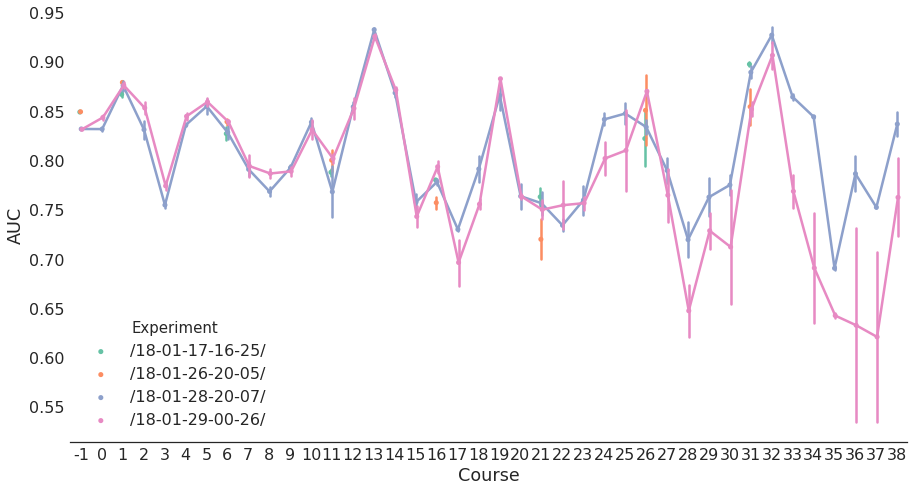

In [190]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='AUC', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True)

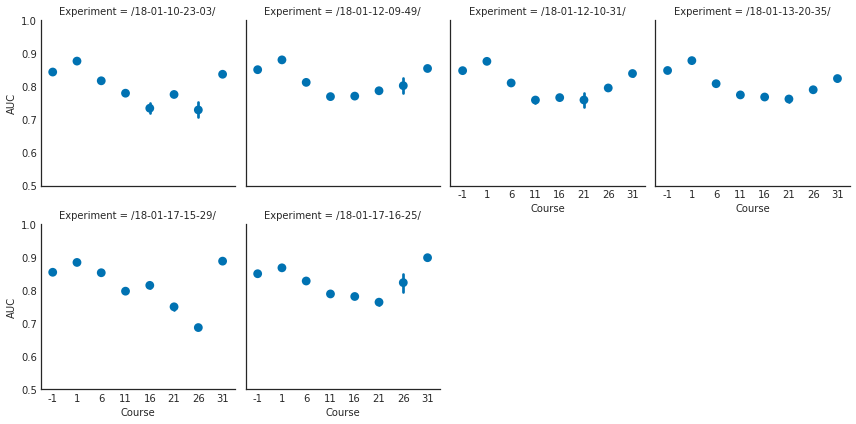

In [76]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0.5, 1], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'AUC', join=False)

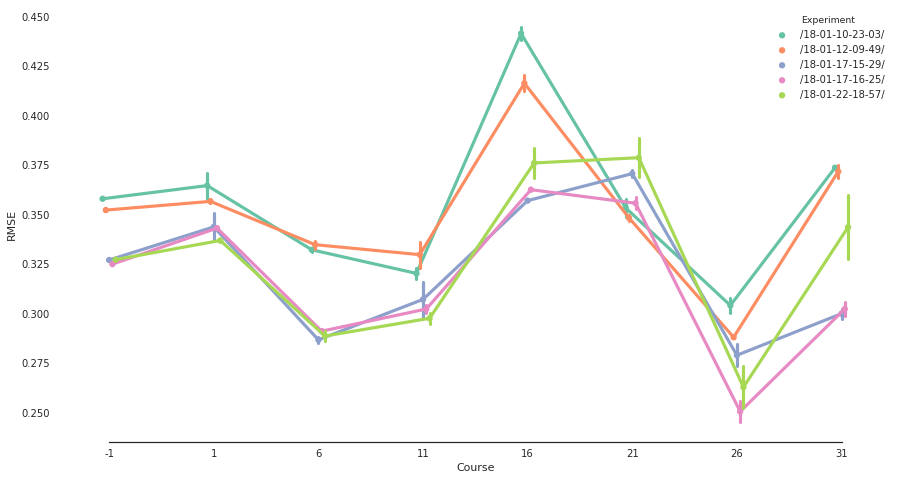

In [158]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=coembedding_metrics.reset_index(), x='Course', y='RMSE', hue='Experiment',
                  dodge=True, palette="Set2", markers=".")
seaborn.despine(left=True, trim=True)

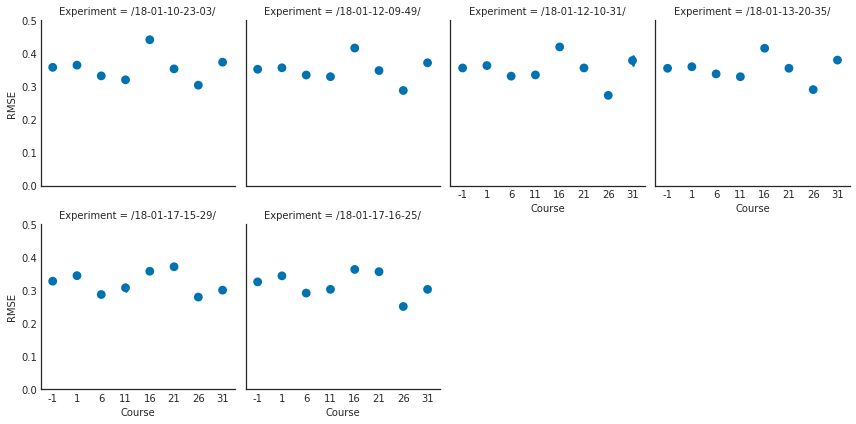

In [78]:
grid = seaborn.FacetGrid(data=coembedding_metrics.reset_index(), col='Experiment', ylim=[0, 0.5], col_wrap=4)
grid.map(seaborn.pointplot, 'Course', 'RMSE', join=False)

# General evaluation

In [106]:
def get_best_metrics(all_metrics_df, DIRNAMES):
    best_performances = all_metrics_df.reset_index().set_index(
        ['Experiment', 'Run']).groupby('Course')['AUC'].apply(numpy.argmax)

    predictions_files = []
    best_metrics = []
    for (course, (experiment, run)) in best_performances.items():
        if course < 0:
            continue
        best_metrics.append((experiment, run, course))
        for dirname in DIRNAMES:
            if experiment in dirname:
                for filename in get_runs(dirname):
                    if '_c{}_'.format(course) in filename and 'run{}.p'.format(run) in filename:
                        predictions_files.append(os.path.join(dirname, filename))

    raw_data = [read_predictions(filename) for filename in predictions_files]
    raw_data = [x for x in zip(*raw_data)]

    true = numpy.concatenate(raw_data[0])
    predicted = numpy.concatenate(raw_data[1])

    return read_file_metrics(true, predicted), all_metrics_df.loc[best_metrics]
    

In [197]:
co_general_metrics, co_best_metrics = get_best_metrics(coembedding_metrics, COEMBEDDING_EXPERIMENTS_DIRS)
co_general_metrics

,AUC,RMSE,Accuracy,R2,PositiveRecall,Support
0,0.851513,0.325755,0.864038,0.36252,0.945496,30810


In [198]:
co_best_metrics.loc[:, 'course_size'] = pandas.cut(co_best_metrics.Support, bins=[50, 500, 1500, 3000],
                                                   labels=['small', 'medium', 'big'])
co_best_metrics.reset_index()[['AUC', 'RMSE', 'R2', 'course_size']].groupby('course_size').agg('mean')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,AUC,RMSE,R2
course_size,,,
small,0.820425,0.311274,0.239609
medium,0.848185,0.312359,0.336514
big,0.851075,0.340950,0.380554


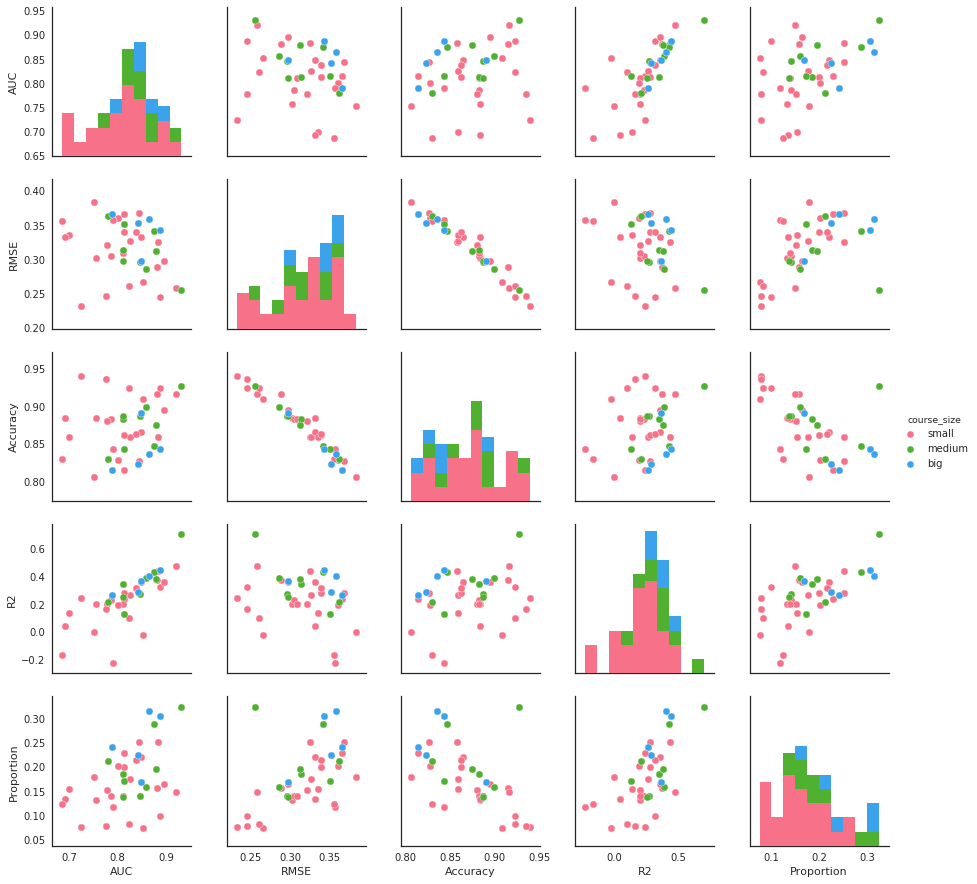

In [32]:
seaborn.pairplot(
    co_best_metrics.reset_index().merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')[METRICS_COLS + ['Proportion', 'course_size']],
    hue='course_size', palette="husl"
)

---

In [199]:
em_general_metrics, em_best_metrics = get_best_metrics(embedding_metrics, EMBEDDING_EXPERIMENTS_DIRS)
em_general_metrics

,AUC,RMSE,Accuracy,R2,PositiveRecall,Support
0,0.842118,0.327272,0.862958,0.353073,0.94311,24124


In [206]:
em_best_metrics.loc[:, 'course_size'] = pandas.cut(em_best_metrics.Support, bins=[50, 500, 1500, 3000],
                                                   labels=['small', 'medium', 'big'])
em_best_metrics.reset_index()[['AUC', 'RMSE', 'R2', 'course_size']].groupby('course_size').agg('mean')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,AUC,RMSE,R2
course_size,,,
small,0.792226,0.318892,0.171670
medium,0.845798,0.309121,0.359695
big,0.849402,0.337692,0.374627


In [139]:
em_best_metrics

AUC      RMSE  Accuracy        R2  \
Experiment       Run Course                                           
/18-01-22-21-50/ 1   0       0.851225  0.346137  0.841316  0.309064   
/18-01-17-14-01/ 1   1       0.889326  0.341721  0.850363  0.448220   
/18-01-22-21-50/ 1   2       0.865212  0.347787  0.845498  0.437755   
                 0   3       0.790714  0.365495  0.826748  0.269135   
                     4       0.850535  0.287320  0.898392  0.408959   
                 1   5       0.876224  0.340995  0.841256  0.431684   
                 0   6       0.854608  0.289021  0.900000  0.372627   
                 1   7       0.809207  0.319641  0.876201  0.321319   
                     8       0.786680  0.366138  0.813225  0.195134   
                     9       0.813402  0.344260  0.839152  0.163280   
                 0   10      0.845123  0.290235  0.891847  0.299385   
/18-01-27-22-16/ 1   11      0.815233  0.286656  0.894825  0.304540   
/18-01-22-21-50/ 1   12      0.875116  0.300681  0.891122  0.422492   
                 0   13      0.936588  0.244464  0.935714  0.726796   
                 1   14      0.883763  0.329510  0.849687  0.421726   
                 0   15      0.732551  0.304088  0.892070  0.193760   
/18-01-17-14-46/ 1   16      0.808049  0.354381  0.832579  0.287625   
/18-01-22-21-50/ 0   17      0.705231  0.232502  0.939675  0.235444   
/18-01-27-22-16/ 0   18      0.786668  0.333711  0.856448  0.229286   
/18-01-22-21-50/ 1   19      0.885635  0.277891  0.905473  0.415666   
                 0   20      0.787215  0.308916  0.885287  0.205738   
/18-01-27-22-16/ 0   21      0.743414  0.385667  0.813953 -0.015244   
                     22      0.770610  0.331605  0.848404  0.145025   
                 1   23      0.783186  0.346754  0.861953  0.244689   
/18-01-22-21-50/ 1   24      0.855245  0.315412  0.881757  0.419485   
/18-01-27-22-16/ 0   25      0.815684  0.252094  0.922034  0.079157   
/18-01-17-14-01/ 0   26      0.860534  0.263132  0.912587  0.216025   
/18-01-22-21-50/ 1   27      0.829996  0.315234  0.875445  0.168620   
/18-01-27-22-16/ 0   28      0.665664  0.352918  0.834677  0.040049   
                     29      0.763956  0.363360  0.846154  0.216589   
                     30      0.781469  0.394959  0.794118  0.031137   
/18-01-17-14-46/ 1   31      0.897694  0.289382  0.861345  0.388807   
/18-01-27-22-16/ 0   32      0.913720  0.236002  0.932489  0.557505   
                 1   33      0.763992  0.410397  0.788462  0.101730   
                 0   34      0.794344  0.241826  0.938462  0.223568   
                 1   35      0.700454  0.344855  0.872222 -0.029159   
                     36      0.757042  0.256313  0.928571  0.085649   
                     37      0.718519  0.362997  0.862745 -0.269350   
                     38      0.716261  0.352612  0.852713 -0.144393   

                             PositiveRecall  Support course_size   Model  
Experiment       Run Course                                               
/18-01-22-21-50/ 1   0             0.897051     2401         big  E-LSTM  
/18-01-17-14-01/ 1   1             0.889353     2065         big  E-LSTM  
/18-01-22-21-50/ 1   2             0.951901     1877         big  E-LSTM  
                 0   3             0.962370     1645         big  E-LSTM  
                     4             0.959815     1555         big  E-LSTM  
                 1   5             0.948810     1178         big  E-LSTM  
                 0   6             0.952727      980      medium  E-LSTM  
                 1   7             0.990838      937      medium  E-LSTM  
                     8             0.900000      862      medium  E-LSTM  
                     9             0.914286      802      medium  E-LSTM  
                 0   10            0.984526      601      medium  E-LSTM  
/18-01-27-22-16/ 1   11            0.967118      599      medium  E-LSTM  
/18-01-22-21-50/ 1   12            0.954262      597      medium  E-LSTM

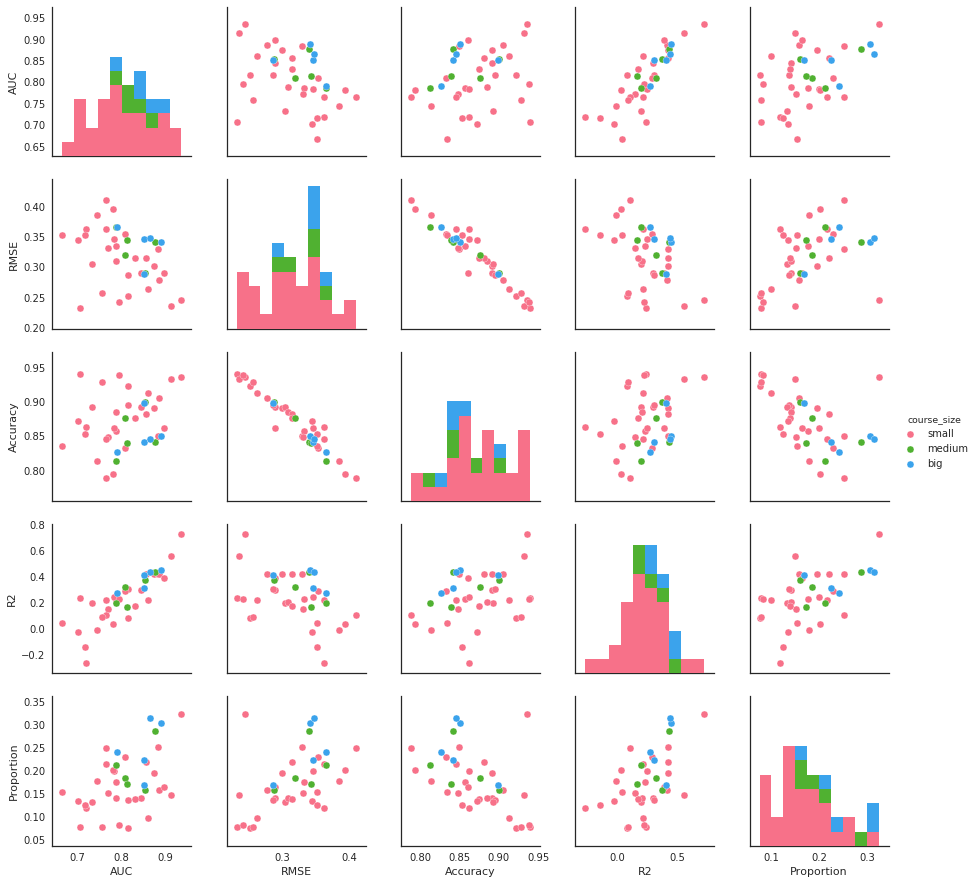

In [112]:
seaborn.pairplot(
    em_best_metrics.reset_index().merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')[METRICS_COLS + ['Proportion', 'course_size']],
    hue='course_size', palette="husl"
)

---

In [155]:
lstm_general_metrics, lstm_best_metrics = get_best_metrics(lstm_metrics, LSTM_EXPERIMENTS_DIRS)
lstm_general_metrics

,AUC,RMSE,Accuracy,R2,PositiveRecall,Support
0,0.830983,0.332685,0.860595,0.331492,0.941747,24124


In [156]:
lstm_best_metrics.loc[:, 'course_size'] = pandas.cut(lstm_best_metrics.Support, bins=[50, 500, 1500, 3000],
                                                   labels=['small', 'medium', 'big'])
lstm_best_metrics.reset_index()[['AUC', 'RMSE', 'R2', 'course_size']].groupby('course_size').agg('mean')

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)


,AUC,RMSE,R2
course_size,,,
small,0.767687,0.331859,0.110950
medium,0.837138,0.314997,0.335178
big,0.843359,0.336407,0.380040


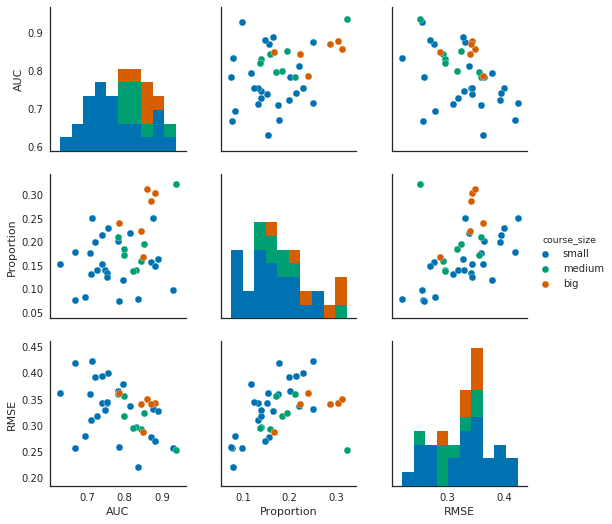

In [136]:
seaborn.pairplot(
    lstm_best_metrics.reset_index().merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course')[['AUC', 'Proportion', 'course_size', 'RMSE']],
    hue='course_size', palette="colorblind"
)

In [204]:
lstm_best_metrics.loc[:,'Model'] = 'LSTM'
em_best_metrics.loc[:,'Model'] = 'E-LSTM'
co_best_metrics.loc[:,'Model'] = 'CoE-LSTM'

/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
/home/mteruel/miniconda3/envs/env_edm2/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


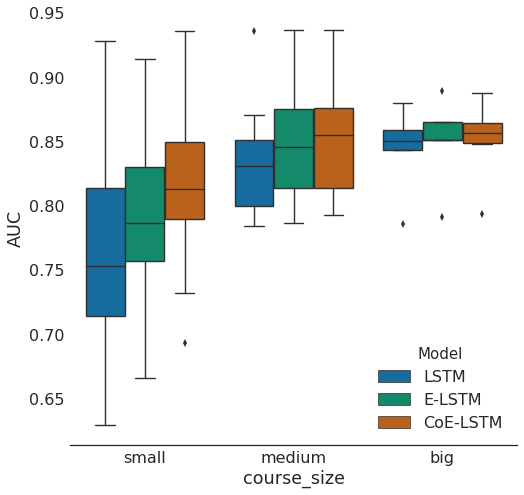

In [207]:
seaborn.set_context("paper", font_scale=2)
plt.subplots(figsize=(8,8))
seaborn.boxplot(data=pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]),
    x='course_size', y='AUC', hue='Model', palette='colorblind')
seaborn.despine(left=True)

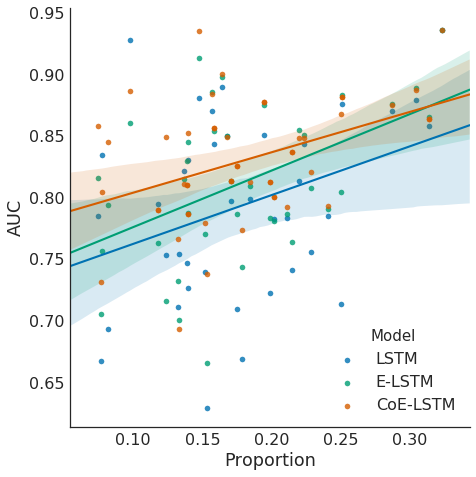

In [208]:
seaborn.set_context("paper", font_scale=2)
seaborn.lmplot(data=pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]).merge(
        dropout_proportions.drop(labels=1, level='Dropout').reset_index()[['Course', 'Proportion']],
        on='Course'),
    x='Proportion', y='AUC', hue='Model', palette='colorblind', legend_out=False, size=7)
seaborn.despine()

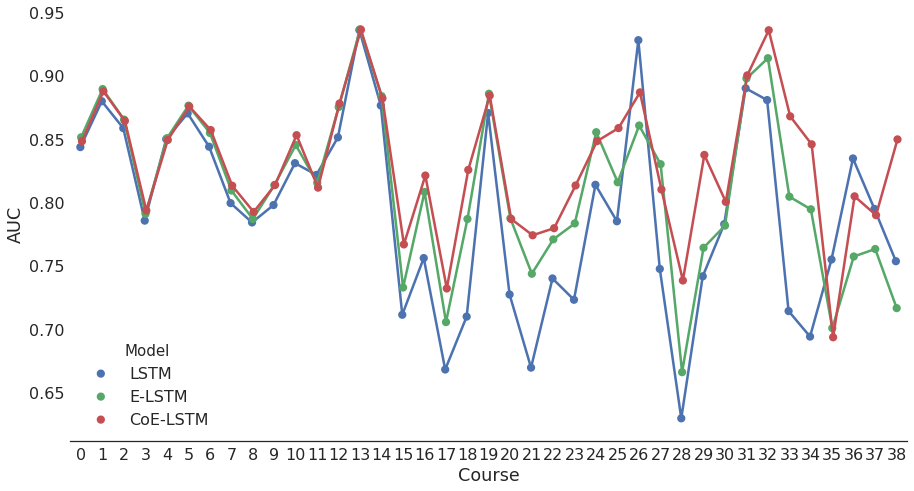

In [203]:
plt.subplots(figsize=(15,8))
seaborn.pointplot(data=pandas.concat(
        [lstm_best_metrics.reset_index(), em_best_metrics.reset_index(),
         co_best_metrics.reset_index()]), x='Course', y='AUC', hue='Model', dodge=True)
seaborn.despine(left=True)